# First Pass - Bernoulli, Coffee Leaf Rust and Python



In [1]:
import pandas as pd
import numpy as np
import scipy
import random
import seaborn as sns

## Make Plant Grid

The plants are organized in an n by n grid for a total of $n^2$ grid squares. There are $y$ number of plants in each grid square and $z$ numbers of leaves on each plant, for a total number of plants of $y*n^2$ and a total number of leaves of $z*y*n^2$

Here we initialize with 5 plants per grid cell, 100 grid cells.

In [2]:
# make a 10 by 10 grid of squares

grid_size = 10
x = np.arange(0,grid_size)
y = np.arange(0,grid_size)
tuples = []
for i in x:
    for j in y:
        tuples.append((i,j))
grid = tuples

# make a list of ids for each plant in each grid square
plants_per_cell = 5
ids = np.arange(0,plants_per_cell)

### Initialize the coffee plants

Each plant $P_j$ is given a number of healthy leaves, infected leaves, and berries. Here we initialize with 100 healthy leaves, 0 infected leaves and 0 berries. The counters of berry and leaf production (explained in the following section) are also initialized to zero.

In [3]:
# initialize coffee plants with 100 healthy leaves, 0 infected leaves, 0 berries, leaf & berry counter set to 0, 
start_h = 100
start_i = 0
start_b = 0
start_lc = 0
start_bc = 0
counts = {'healthy':start_h,'infected':start_i,'berries':start_b,'lcount':start_lc,'bcount':start_bc}

Now that the all of the properties of our coffee plants are created, we can initialize the coffee plant objects. First we define the class object and then iterate  over the grid cells and id numbers to fill up the grid with coffee plants.

*Likely Bonus: Draw the number of leaves for each plant randomly from a distribution of number of leaves from the literature*

In [4]:
class CoffeePlant:
    def __init__(self, grid=None, id_no=None, counts = None):
        self.grid = grid
        self.id_no = id_no
        self.counts = counts
    
    def close_neighbors(self):
        # get x coord
        x = self.grid[0]
        # get y coord
        y = self.grid[1]
        # list of touching grid neighbors (not corners)
        neighbors = [(x-1,y),(x+1,y),(x,y-1),(x,y+1)]
        # remove negative neighbors, neighbors more than 100
        return [x for x in neighbors if ~((x[0]<0) | (x[1]<0) | (x[0]>100) | (x[1]>100))]
    
    def set_counts(self,counts):
        self.counts = counts

In [5]:
# initialize coffee plants looping over grid and ids
coffee_plants = []
for i in grid:
    for j in ids:
        plant = CoffeePlant(i,j,counts)
        coffee_plants.append(plant)

## Plant production
This section defines the state equations for the production of leaves and berries.

### Berry production

Let the number of berries $B_{(j,k)_t}$ on each plant $j$ in a given grid cell $k$ in each time period $t$ be given by the following functions. Let $x$ be the number of berry days $BD_{(j,k)}$ needed to produce one coffee berry $B_{(j,k)}$.

Each healthy leaf $HL_{(i,j,k)_{t-1}}$ and infected leaf $IL_{(i,j,k)_{t-1}}$ produces a number of berry days, $BD_{(j,k)_t}$ for each time period $t$ at a rate of $\alpha$  and $\beta$ respectively. Thus, the number of berry-days in each time period $t$ is:

$$
BD_{(j,k)_t} = BD_{(j,k)_{t-1}} + \alpha*HL_{(j,k)_{t-1}} + \beta*IL_{(j,k)_{t-1}} 
$$

Then, for a given cut-off $x$, the number of berries produced is given by:
$$
B_{(j,k)_t} = B_{(j,k)_{t-1}}  + floor(BD_{(j,k)_{t-1}}/x)
$$

where $\beta$ is the number of leaf-berry-days made by a diseased leaf, $\alpha$ is the number of berry-days made by a healthy leaf, and ```floor``` returns the highest integer in the division. (round down).

Keeping the remaining berry-days we have

$$
BD_{(j,k)_t} = BD_{(j,k)_{t-1}} - floor(BD_{(j,k)_{t-1}}/x)*x
$$


In [6]:
# define production functions for leaves and berries on each branch

berry_cutoff = 50
berry_days_healthy = .2
berry_days_infected = .01

def make_berries(coffee_plant):
    berry_days = berry_days_healthy*coffee_plant.counts['healthy'] + berry_days_infected*coffee_plant.counts['infected'] + coffee_plant.counts['bcount']
    berries = coffee_plant.counts['berries'] + np.floor(berry_days/berry_cutoff)
    berry_days = berry_days - berry_cutoff*np.floor(berry_days/berry_cutoff)
    coffee_plant.set_counts({'healthy':coffee_plant.counts['healthy'],'infected':coffee_plant.counts['infected'],'berries':berries,
                             'lcount':coffee_plant.counts['lcount'],'bcount':berry_days})

### Leaf production

Let the number of leaf days $LD_{(j,k)_t}$ made by each plant $j$ in each grid $k$ for each time period $t$ be given by the following pay off-function equation in Leaf-Days :

$$
LD_{(j,k)_t} = LD_{(j,k)_{t-1}} + \gamma*HL_{(j,k)_{t-1}} + \theta*IL_{(j,k)_{t-1}}
$$

where $\theta$ is the number of leaf-days made by an infected leaf and $\gamma$ is the number of leaf-days made by a healthy leaf.

Then, when $LD_t$ crossses a threshold value $x$ (or accumulates enough leaf-days), a new leaf on the branch is produced. The evolution of leaves is given by the following code:

$$
L_{(j,k)_t} = L_{(j,k)_{t-1}}  + floor(LD_{(j,k)_t}/x)
$$

In [7]:
leaf_cutoff = 50
leaf_days_healthy = .1
leaf_days_infected = .05

def make_leaves(coffee_plant):
    leaf_days = leaf_days_healthy*coffee_plant.counts['healthy'] + leaf_days_infected*coffee_plant.counts['infected'] + coffee_plant.counts['lcount']
    healthy = coffee_plant.counts['healthy'] + np.floor(leaf_days/leaf_cutoff)
    leaf_days = leaf_days - leaf_cutoff*np.floor(leaf_days/leaf_cutoff)
    coffee_plant.set_counts({'healthy':healthy,'infected':coffee_plant.counts['infected'],'berries':coffee_plant.counts['berries'],
                             'lcount':leaf_days,'bcount':coffee_plant.counts['bcount']})

### The virus state equations

Let the chance of an infected leaf $il_{(i,j,k)_t}$ transmitting the virus to a healthy leaf $hl_{(i,j,k)_t}$ on the same plant be $\theta$.

Let the chance of an infected leaf $il_{(i,-j,k)_t}$ from a different plant $-j$ transmitting the virus to a healthy leaf $hl_{(i,j,k)_t}$ on plant $j$ be $\phi$.

For each time period let the probability that a healthy leaf becomes infected be modelled as a series of independent bernoulli trials. Let $HL_{(i,j,k,l)_t}$ and $IL_{(i,j,k)_t}$ be the total number of healthy and infected leaves on plant j at time $t$ respectively and let $IL_{(i,-j,k)_t}$ be the number of infected leaves on different plants in the same grid at time $t$. Starting with the infected leaves on the same plant, we have for each $hl_{(i,j,k,l)_t}$

$$
P(Infected)_{t-1} = \theta_{(i,j,k)_{t-1}} = 1- P(NotInfected)_{t-1}
$$
$$
\theta_{(i,j,k)_{t-1}} = 1- {IL_{(j,k)_{t-1}} \choose 0}*\theta^0*(1-\theta)^{IL_{(j,k)_{t-1}}} + 
$$

$$\theta_{(i,j,k)_{t-1}} = 1- (1-\theta)^{IL_{(j,k)_{t-1}}}$$ 

Then further assuming independence, the number of healthy leaves that became infected is given by the following:

$$
IL_{(j,k)_{t}} = IL_{(j,k)_{t-1}} + HL_{(j,k)_{t-1}}*\theta_{(i,j,k)_{t-1}}
$$
And the number of healthy leaves follows:
$$
HL_{(j,k)_t} = HL_{(j,k)_{t-1}} - HL_{(j,k)_{t-1}}*\theta_{(i,j,k)_{t-1}}
$$

But since cross plant infection occurs at rate $\phi$ for each each infected leaf $il_{(i,-j,k)_t}$ on the other plants in the grid square then the probability of infecting a healthy leaf on a given branch $hl_{(i,j,k,l)_t}$ by an infected leaf from another plant is given by summing across all infected leaves on all plants but plant $j$. Following the reasoning above:

$$
P(Infected)_{t-1} = \phi_{(i,j,k)_{t-1}} = 1- P(NotInfected)_{t-1}
$$
$$
\phi_{(i,j,k)_{t-1}} = 1- {IL_{(-j,k)_{t-1}} \choose 0}*\phi^0*(1-\phi)^{IL_{(-j,k)_{t-1}}}
$$

$$\phi_{(i,j,k)_{t-1}} = 1- (1-\phi)^{IL_{(-j,k)_{t-1}}}$$ 

So the number of leaves infected by neighboring plants on plant $j$ and the number of healthy leaves remaining is:
$$
IL_{(j,k)_{t}} = IL_{(j,k)_{t-1}} + HL_{(j,k)_{t-1}}*\phi_{(i,j,k)_{t-1}}
$$
And the remaining healthy leaves:
$$
HL_{(j,k)_{t}} = HL_{(j,k)_{t-1}} - HL_{(j,k)_{t-1}}*\phi_{(i,j,k)_{t-1}}
$$

Putting it all together the actual probability of infection for each healthy leaf on a given branch $j$ on a given plant $k$, for a given grid square $l$, again assuming independence between all infection events, is:

$$
\beta_{(i,j,k)_{t-1}} = \theta_{(i,j,k)_{t-1}} + \phi_{(i,j,k)_{t-1}} - \phi_{(i,j,k)_{t-1}}*\theta_{(i,j,k)_{t-1}}
$$

We then use $\beta_{(i,j,k,l)_{t-1}}$ to calculate 

$$
HL_{(j,k)_{t}} = HL_{(j,k)_{t-1}}- \beta_{(i,j,k)_{t-1}}*HL_{(j,k)_{t-1}}
$$

*Bonus: We will assume that transmission between grid cells occurs only during a storm. Let $\delta$ be the probability of the storm and $\alpha$ represent the likeliehood of cross grid contamination if a storm occurs...*

*Bonus: some wind transmission*

In [8]:
# chance of spread from leaf to leaf on same plant
spread_j = 0.005

# chance of spread from leaf to leaf on new plant same grid
spread_k = 0.00005


def virus_spread(coffee_plant,coffee_plants):
    grid_plants = [x for x in coffee_plants if (x.grid == coffee_plant.grid)]
    infected_others = 0
    for i in grid_plants:
        if i is not coffee_plant:
            infected_others = infected_others + i.counts['infected']
    phi = 1-(1-spread_k)**infected_others
    theta = 1-(1-spread_j)**(coffee_plant.counts['infected'])
    beta = phi + theta - phi*theta
    infected = coffee_plant.counts['infected']+np.round(coffee_plant.counts['healthy']*beta)
    healthy = coffee_plant.counts['healthy']-np.round(coffee_plant.counts['healthy']*beta)
    coffee_plant.set_counts({'healthy':healthy,'infected':infected,'berries':coffee_plant.counts['berries'],
                             'lcount':coffee_plant.counts['lcount'],'bcount':coffee_plant.counts['bcount']})

## Make some virus
Now that we have the virus state functions defined, we can initiate the virus.

All plants with id_no 2 (100 plants, one in each cell) get 2 infected leaves.

In [9]:
for i in coffee_plants:
    if i.id_no == 2:
        healthy = i.counts['healthy']-5
        i.set_counts({'healthy':healthy,'infected':5,'berries':i.counts['berries'],
                             'lcount':i.counts['lcount'],'bcount':i.counts['bcount']})

So for each timestamp $t$ we run the following with (for now) a simple print statement to represent the data:

In [11]:
for i in range(100):
    counts = []
    for j in coffee_plants:
        make_leaves(j)
        make_berries(j)
        virus_spread(j,coffee_plants)
        counts.append(j.counts)
    if i == 0:
        df = pd.DataFrame(counts)
        df['t'] = i
    else:
        newdf = pd.DataFrame(counts)
        newdf['t'] = i
        df = pd.concat([df,newdf],axis=0)

In [12]:
a = df.groupby('t').mean()

<AxesSubplot:title={'center':'Infected and Healthy leaves over time t'}, xlabel='t', ylabel='infected'>

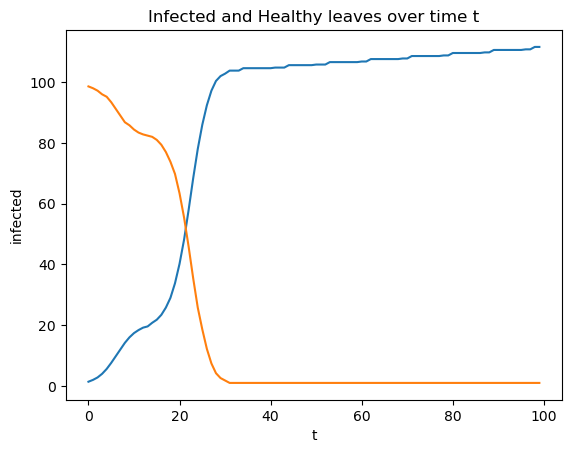

In [17]:
import matplotlib.pyplot as plt
plt.title('Infected and Healthy leaves over time t')
sns.lineplot(data=a,x=a.index,y = 'infected')
sns.lineplot(data=a,x=a.index,y = 'healthy')

<AxesSubplot:xlabel='t', ylabel='berries'>

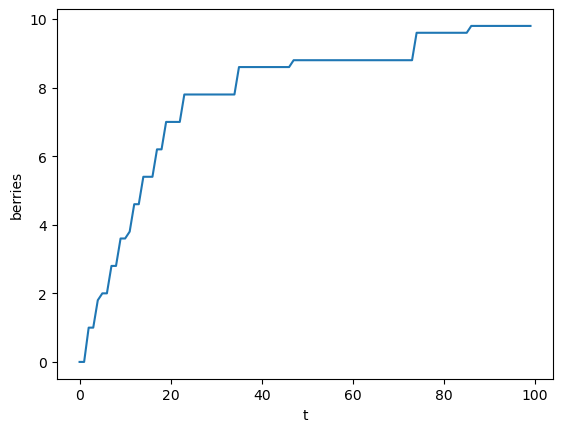

In [18]:
sns.lineplot(data=a,x=a.index,y = 'berries')